In [1]:
############################################################################################
# IMPORTS
############################################################################################
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay


import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
#import tensorflow.keras as keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers


from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical



from IPython import display
from PIL import Image


import pathlib
import shutil
import tempfile
import concurrent


import json
import glob





print(tf.__version__)
print(tf.config.list_physical_devices())
############################################################################################

2025-01-02 10:03:23.526508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735808603.556519  936970 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735808603.565401  936970 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 10:03:23.595787: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
############################################################################################
# 1. CONSTANTS - PATHS
############################################################################################

#DATA_FS251 = './data/iFood_2019'
DATA_FS251 = './data/food-101'
CLASSES_FILE_NAME = '/formated_annot/classes_formated.csv'

TRAIN_INFO = '/annot/train_info.csv'
VAL_INFO = '/annot/val_info.csv'
TEST_INFO = '/annot/test_info.csv'

TRAIN_PICS_PATH = './data/iFood_2019/train_set/'
TEST_PICS_PATH = './data/iFood_2019/test_set/'
VAL_PICS_PATH = './data/iFood_2019/val_set/'

MODELS = './models/'

SEED = 111

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
gpu_dev = tf.config.experimental.list_physical_devices('GPU')
for itm in gpu_dev:
    tf.config.experimental.set_memory_growth(itm, True)


############################################################################################
# IMPORTING DATA
############################################################################################
df_classes = pd.read_csv(DATA_FS251 + CLASSES_FILE_NAME)
df_train = pd.read_csv(DATA_FS251 + TRAIN_INFO, names=['file_name', 'class_num'])
df_validate = pd.read_csv(DATA_FS251 + VAL_INFO, names=['file_name', 'class_num'])
df_test = pd.read_csv(DATA_FS251 + TEST_INFO, names=['file_name'])

df_train.head(3)

In [3]:
############################################################################################
# 2. CONSTANTS - MODEL
############################################################################################
training_history = dict()

#N_TRAIN = len(df_train.iloc[:, 0])
EPOCHS = 20
BATCH_SIZE = 8              # 8 fit into GPU RAM, 64 fit into system RAM
WIDTH = 380
HEIGHT = 380
RESIZE_TO = (WIDTH, HEIGHT)
#STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

############################################################################################
# FUNCTIONS, DEFFINITIONS
############################################################################################

class CRelu(tf.keras.Layer):
    def __init__(self, axis=-1, **kwargs):
        self.axis = axis 
        super(CRelu, self).__init__(**kwargs)

    def build(self, input_shape):
        super(CRelu, self).build(input_shape)

    def call(self, x):
        x = tf.nn.crelu(x, axis=self.axis)
        return x

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[-1] = output_shape[-1] * 2
        output_shape = tuple(output_shape)
        return output_shape

    def get_config(self, input_shape):
        config = {'axis': self.axis, }
        base_config = super(CReLU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
############################################################################################
# import image files
############################################################################################

train_pics, val_pics = tf.keras.preprocessing.image_dataset_from_directory(
    './data/food-101/images/',
    labels='inferred',
#    label_mode='int',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=RESIZE_TO,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='both',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format='channels_last',
    verbose=True
)
#test_pics = tf.keras.preprocessing.image_dataset_from_directory(
#    VAL_PICS_PATH,
#    labels='inferred',
#    label_mode='int',
#    label_mode='categorical',
#    class_names=None,
#    color_mode='rgb',
#    batch_size=BATCH_SIZE,
#    image_size=RESIZE_TO,
#    shuffle=True,
#    seed=SEED,
#    validation_split=None,
#    subset=None,
#    interpolation='bilinear',
#    follow_links=False,
#    crop_to_aspect_ratio=False,
#    pad_to_aspect_ratio=False,
#    data_format='channels_last',
#    verbose=True
#)
#true_test_pics = tf.keras.preprocessing.image_dataset_from_directory(
#    TEST_PICS_PATH,
#    labels=None,
#    label_mode=None,
#    class_names=None,
#    color_mode='rgb',
#    batch_size=BATCH_SIZE,
#    image_size=RESIZE_TO,
#    shuffle=True,
#    seed=SEED,
#    validation_split=None,
#    subset=None,
#    interpolation='bilinear',
#    follow_links=False,
#    crop_to_aspect_ratio=False,
#    pad_to_aspect_ratio=False,
#    data_format='channels_last',
#    verbose=True
#)

Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Using 20200 files for validation.


I0000 00:00:1735808616.842492  936970 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5456 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1


In [5]:
train_pics.class_names
#val_pics.as_numpy_iterator().next()[0]
#val_pics.take(1)

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
############################################################################################
# DEFINING THE MODEL
############################################################################################

# (None, 19, 19, 2560) - B7 - 600x600
# (None, 17, 17, 2304) - B6 - 528x528
# (None, 17, 17, 2048) - B5 - 456x456   - maximum model starting on gt1060 6gb (batch=1)
# (None, 12, 12, 1792) - B4 - 380x380   - maximum batch for 1060 - batch=8
# (None, 10, 10, 1536) - B3 - 300x300   - maximum batch for 1060 - batch=16
# (None, 10, 10, 1408) - B2 - 260x260   
# (None, , , ) - B1 - 240x240
# (None, , , ) - B0 - 224x224
tf.keras.backend.clear_session()

core_model = tf.keras.applications.EfficientNetB4(include_top=False, input_shape=(WIDTH, HEIGHT, 3))
for layer in core_model.layers[-5:]:
    print(layer.output)

core_model.trainable = True
#for layer in core_model.layers[:-5]:
#    layer.trainable = False

inputed = tf.keras.Input(shape=(WIDTH,HEIGHT,3))
x = tf.keras.layers.Resizing(height = HEIGHT,width = WIDTH,interpolation='bilinear',crop_to_aspect_ratio=False,pad_to_aspect_ratio=False,fill_mode='constant',fill_value=0.0)(inputed)
x = core_model(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation='relu', activity_regularizer=tf.keras.regularizers.L2())(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation='relu', activity_regularizer=tf.keras.regularizers.L2())(x)
x = tf.keras.layers.BatchNormalization()(x)
outputed = tf.keras.layers.Dense(units=101,activation='softmax',activity_regularizer=tf.keras.regularizers.L2(), name='Output_layer')(x)


model_supclass = tf.keras.Model(inputed,outputed)

model_supclass.summary()


<KerasTensor shape=(None, 12, 12, 448), dtype=float32, sparse=False, name=keras_tensor_470>
<KerasTensor shape=(None, 12, 12, 448), dtype=float32, sparse=False, name=keras_tensor_471>
<KerasTensor shape=(None, 12, 12, 1792), dtype=float32, sparse=False, name=keras_tensor_472>
<KerasTensor shape=(None, 12, 12, 1792), dtype=float32, sparse=False, name=keras_tensor_473>
<KerasTensor shape=(None, 12, 12, 1792), dtype=float32, sparse=False, name=keras_tensor_474>


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 12, 12, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 12, 12, 512)    │     8,258,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73728)          │       294,912 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    75,498,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,018,756 (389.17 MB)

 Trainable params: 101,743,533 (388.12 MB)

 Non-trainable params: 275,223 (1.05 MB)

In [7]:
#STOP

In [8]:
############################################################################################
# SCHEDULER PARAMS
############################################################################################
#lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#    0.00005, #0.000005
#    decay_steps=STEPS_PER_EPOCH*100, #100
#    decay_rate=1,
#    staircase=False)

In [9]:
############################################################################################
# COMPILING
############################################################################################

model_supclass.compile(
#        optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),                     
#        optimizer = tf.keras.optimizers.Adam(),                                     #
#        optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.5),                 #3            
#        optimizer = tf.keras.optimizers.Adagrad(),                                             
#        optimizer = tf.keras.optimizers.Adam(0.05),
#        optimizer = tf.keras.optimizers.Nadam(),
#        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.05),                 #1
        optimizer = tf.keras.optimizers.Nadam(learning_rate=0.5),                  #2
#        loss = tf.keras.losses.CTC(),
#        loss = tf.keras.losses.KLDivergence(),
        loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
#        loss = tf.keras.losses.BinaryCrossentropy(),
#        loss = tf.keras.losses.CategoricalCrossentropy(),
#        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
#        metrics = [tf.keras.metrics.CategoricalCrossentropy(from_logits=False, label_smoothing=0.2, axis=-1),
#                   tf.keras.metrics.F1Score(average=None, threshold=0.5, dtype=None),
#                   tf.keras.metrics.CategoricalAccuracy()]
        metrics = [tf.keras.metrics.Accuracy()]
#        metrics = [tf.keras.metrics.F1Score(average='micro', threshold=0.5),tf.keras.metrics.CategoricalAccuracy()]
        )

In [10]:
############################################################################################
# FITTING
############################################################################################


with tf.device('/GPU:0'):
    model_history = model_supclass.fit(
        train_pics,
        epochs = EPOCHS, 
        batch_size = BATCH_SIZE,
        callbacks = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=5,
                            patience=5,
                            verbose=1,
                            mode='auto',
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0
                            ),
        validation_data = val_pics
#        validation_split = 0.1
    )

Epoch 1/20


I0000 00:00:1735808763.463101  937218 service.cc:148] XLA service 0x7a73a8004e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735808763.463134  937218 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 with Max-Q Design, Compute Capability 6.1
2025-01-02 10:06:07.354660: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735808778.658269  937218 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-01-02 10:06:38.071560: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[8,512,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,1792,12,12]{3,2,1,0}, f32[512,1792,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudn

10100/10100 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.8725 - loss: 50649.2148

2025-01-02 11:41:47.070239: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[8,512,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,1792,12,12]{3,2,1,0}, f32[512,1792,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-02 11:41:47.567010: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


10100/10100 ━━━━━━━━━━━━━━━━━━━━ 6192s 588ms/step - accuracy: 0.8725 - loss: 50645.4062 - val_accuracy: 0.9146 - val_loss: 3900334026545715623231488.0000
Epoch 2/20
10100/10100 ━━━━━━━━━━━━━━━━━━━━ 5849s 579ms/step - accuracy: 0.8958 - loss: 327.9736 - val_accuracy: 0.9327 - val_loss: 137701999156085502509056.0000
Epoch 3/20
10100/10100 ━━━━━━━━━━━━━━━━━━━━ 5829s 577ms/step - accuracy: 0.8948 - loss: 326.2251 - val_accuracy: 0.9333 - val_loss: 976928325158987936825344.0000
Epoch 4/20
10100/10100 ━━━━━━━━━━━━━━━━━━━━ 5826s 577ms/step - accuracy: 0.8960 - loss: 327.6461 - val_accuracy: 0.9052 - val_loss: 1446187986005869503447040.0000
Epoch 5/20
10100/10100 ━━━━━━━━━━━━━━━━━━━━ 5826s 577ms/step - accuracy: 0.8963 - loss: 336.4191 - val_accuracy: 0.9144 - val_loss: 1822000044255040377978880.0000
Epoch 6/20
10100/10100 ━━━━━━━━━━━━━━━━━━━━ 5831s 577ms/step - accuracy: 0.8933 - loss: 323.0985 - val_accuracy: 0.9427 - val_loss: 1229212626409691254095872.0000
Epoch 7/20
10100/10100 ━━━━━━━━━━

In [11]:
############################################################################################
# SAVING MODEL
############################################################################################
MODEL_NAME = 'food-101-EfNeetB4-A0.90-E(20)-earlystop-B8'
os.makedirs( os.path.dirname(MODELS + MODEL_NAME + '/'), exist_ok=True)
model_supclass.save(MODELS + MODEL_NAME + '/'+ MODEL_NAME + ".keras")
model_supclass_loaded = load_model(MODELS + MODEL_NAME + '/'+ MODEL_NAME + ".keras")
model_supclass_loaded.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 12, 12, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 12, 12, 512)    │     8,258,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73728)          │       294,912 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    75,498,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,505,825 (1.14 GB)

 Trainable params: 101,743,533 (388.12 MB)

 Non-trainable params: 275,223 (1.05 MB)

 Optimizer params: 203,487,069 (776.24 MB)

In [12]:
############################################################################################
# EVALUATION - ACCURACY
############################################################################################
#model_supclass.evaluate()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 324s 123ms/step - accuracy: 0.9328 - loss: 82149287104537507659776.0000
[1.377019991560855e+23, 0.9327327609062195] ['loss', 'compile_metrics']


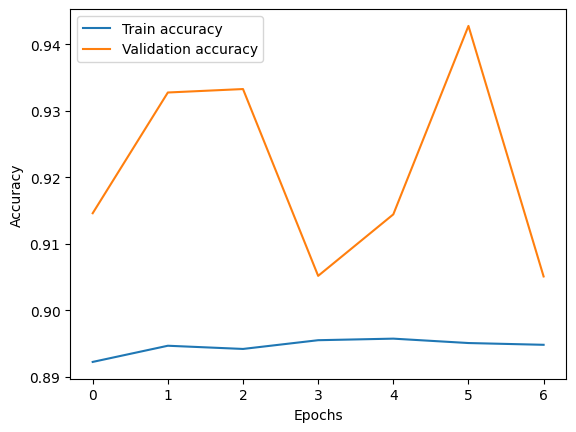

In [13]:
############################################################################################
# EVALUATION - ACCURACY
############################################################################################

plt.legend(bbox_to_anchor = [1, 1.02])
plt.plot(model_history.history['accuracy'],label='Train accuracy')
plt.plot(model_history.history['val_accuracy'],label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Print out the score
score = model_supclass_loaded.evaluate(val_pics , batch_size=1, verbose=1)
print(score, model_supclass_loaded.metrics_names)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2525/2525 ━━━━━━━━━━━━━━━━━━━━ 310s 123ms/step - accuracy: 0.9328 - loss: 82149287104537507659776.0000
[1.377019991560855e+23, 0.9327327609062195] ['loss', 'compile_metrics']


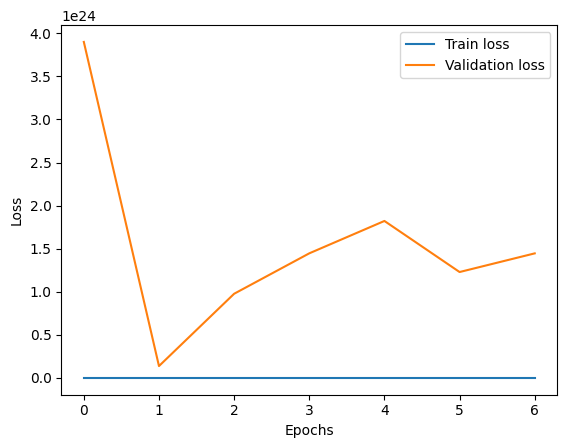

In [14]:
############################################################################################
# EVALUATION - LOSS
############################################################################################

plt.legend(bbox_to_anchor = [1, 1.02])
plt.plot(model_history.history['loss'],label='Train loss')
plt.plot(model_history.history['val_loss'],label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Print out the score
score = model_supclass_loaded.evaluate(val_pics , batch_size=1, verbose=1)
print(score, model_supclass_loaded.metrics_names)

In [15]:
############################################################################################
# PREDICTION
############################################################################################

y_test_pred = np.array([])
y_test =  np.array([])
for x, y in val_pics:
        y_test_pred = np.concatenate([y_test_pred, np.argmax(model_supclass.predict(x, verbose=0), axis = -1)])
        y_test = np.concatenate([y_test, np.argmax(y.numpy(), axis=-1)])

2025-01-02 21:51:34.563036: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


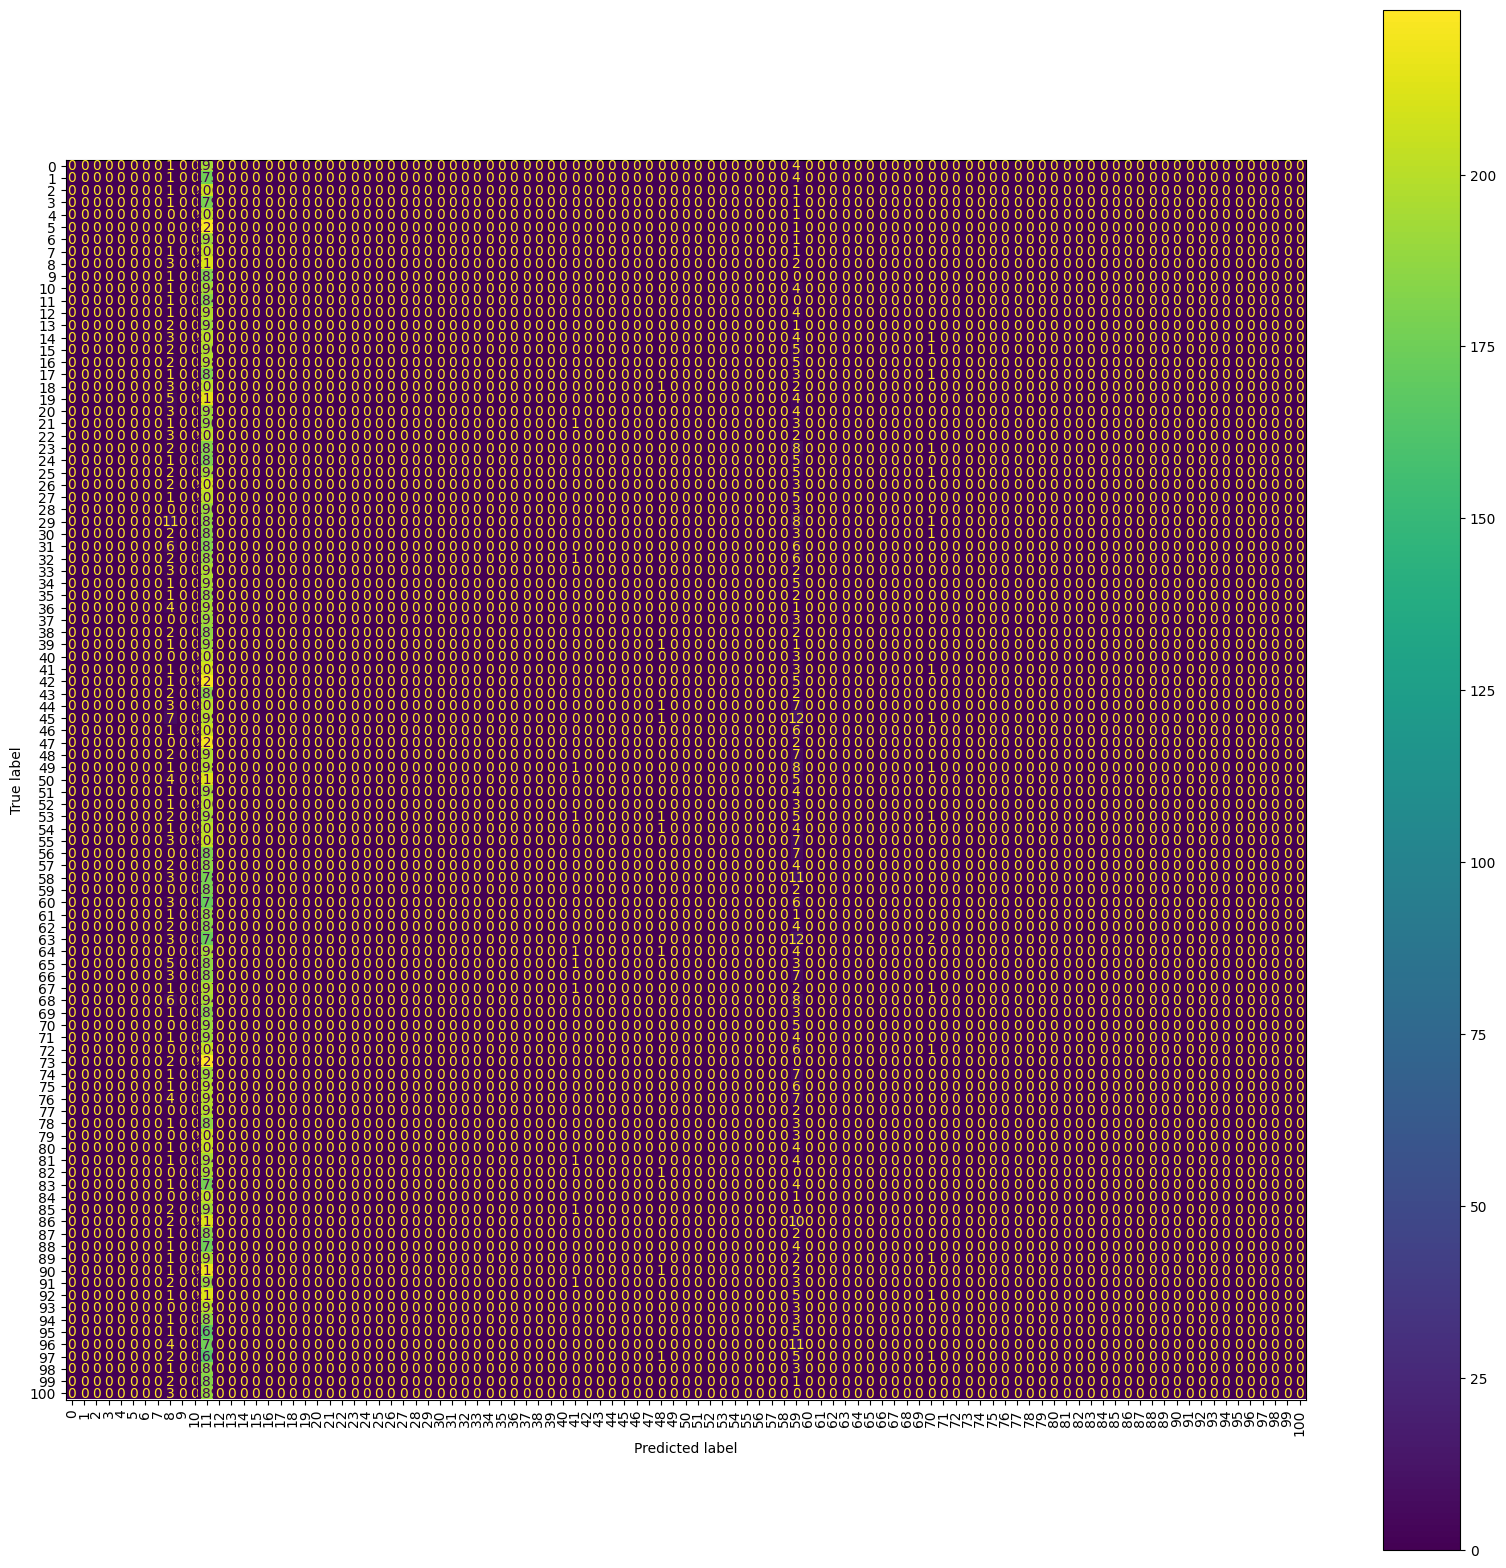

In [16]:
############################################################################################
# PREDICTION - CONFMATRIX
############################################################################################

from sklearn.metrics import ConfusionMatrixDisplay
plt.rcParams['figure.figsize'] = (20, 20)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true= y_test, y_pred=y_test_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks(rotation=90)
plt.show()






ValueError: as_list() is not defined on an unknown TensorShape.

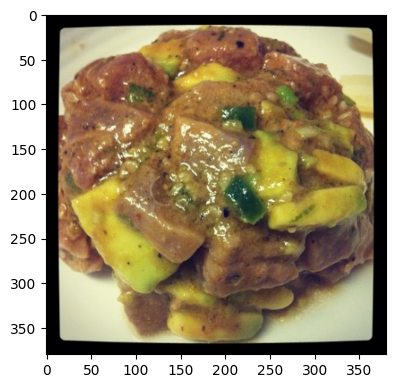

In [17]:
plt.figure(figsize=(15, 15))
for images, labels in val_pics.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str( labels[i].numpy().astype(int) ) + str(np.argmax(model_supclass.predict(images[i], verbose=0), axis = -1))  )
        plt.axis("off")
        

In [ ]:
#plt.imshow(images[0].numpy().astype("uint8"))
#plt.show()
